# Mini Hydrogen Case Study

In [1]:
import bw2data as bd
from datetime import datetime

/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


In [2]:
bd.projects.set_current("optimex_test")

In [3]:
if "foreground" in bd.databases:
    del bd.databases["foreground"] # to make sure we create the foreground from scratch
foreground = bd.Database("foreground")
foreground.register()

In [4]:
bg_h2_smr = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="hydrogen production, steam methane reforming", location="EUR")

bg_h2_pem = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity", location="EUR")

In [5]:
hydrogen = foreground.new_node(
    name="hydrogen",
    unit="kg",
    type=bd.labels.product_node_default,
)
hydrogen.save()

Processes:

In [6]:
def productify(background_node, new_product_node, foreground_db_name="foreground", process_name=None, process_location="GLO"):
    """
    Copies a background process to the foreground database as a new process producing a new, 
    explicit product. Keeps all non-production exchanges the unchanged. Essentially turning a 
    "processwithreferenceproduct" into a "process". Products need to be created as new nodes 
    beforehand.
    """
    assert (
        len(background_node.production()) == 1
    ), "Multifunctional process, not sure what to do"

    fg = bd.Database(foreground_db_name)

    new_name = process_name if process_name else background_node["name"]
    new_location = process_location if process_location else background_node["location"]
    
    new_process_node = fg.new_node(
        name=new_name,
        location=new_location,
        type=bd.labels.process_node_default,
    )
    new_process_node.save()

    new_process_node.new_edge(
        input=new_product_node,
        amount=1.0,
        type=bd.labels.production_edge_default,
    ).save()

    for exc in background_node.technosphere():
        new_process_node.new_edge(
            input=exc.input,
            amount=exc.amount,
            type=bd.labels.consumption_edge_default,
        ).save()

    for exc in background_node.biosphere():
        new_process_node.new_edge(
            input=exc.input,
            amount=exc.amount,
            type=bd.labels.biosphere_edge_default,
        ).save()

    return new_process_node

In [ ]:
# bg_dac = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="carbon dioxide, captured, with a solvent-based direct air capture system, 1MtCO2", location="RER")
# bg_cc_cement = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="carbon dioxide, captured at cement production plant, integrated in fuel production chain", location="RER")

# cc_cement = productify(bg_cc_cement, captured_co2, process_name="carbon capture at cement plant", process_location="RER")
# dac = productify(bg_dac, captured_co2, process_name="direct air capture", process_location="RER")

# productify(bg_meoh_biomass_gasification, methanol, process_name="methanol from biomass gasification", process_location="EUR")
# productify(bg_meoh_wood_ccs, methanol, process_name="methanol from wood with CCS", process_location="RER")
# productify(bg_meoh_ng, methanol, process_name="methanol from natural gas", process_location="RER")
# productify(bg_meoh_h2_cement, methanol, process_name="methanol from H2 and cement CO2", process_location="RER")


In [7]:
h2_smr = productify(bg_h2_smr, hydrogen, process_name="hydrogen from SMR", process_location="EUR")
h2_pem = productify(bg_h2_pem, hydrogen, process_name="hydrogen from PEM electrolysis", process_location="EUR")

In [8]:
from bw_temporalis import easy_timedelta_distribution

In [9]:
h2_smr["operation_time_limits"] = (0, 15)
for exc in h2_smr.exchanges():
    exc["temporal_distribution"] = easy_timedelta_distribution(start=0, end=15, steps=16, kind="uniform", resolution="Y")
    exc["operation"] = True
    exc.save()
h2_smr.save()

In [10]:
h2_pem["operation_time_limits"] = (0, 5)
for exc in h2_pem.exchanges():
    exc["temporal_distribution"] = easy_timedelta_distribution(start=0, end=5, steps=6, kind="uniform", resolution="Y")
    exc["operation"] = True
    exc.save()
h2_pem.save()

In [11]:
# bg_meoh_h2 = bd.get_node(database="ei311_REMIND_SSP2_PkBudg650_2020", name="methanol synthesis, hydrogen from electrolysis, CO2 from DAC", location="RER")

# meoh_from_h2 = foreground.new_node(
#     name="methanol production from hydrogen",
#     location="RER",
#     type=bd.labels.process_node_default,
# )
# meoh_from_h2.save()

# meoh_from_h2.new_edge(
#     input=methanol,
#     amount=1.0,
#     type=bd.labels.production_edge_default,
# ).save()

# for exc in bg_meoh_h2.technosphere():
#     if "carbon dioxide, captured" in exc.input["name"].lower():
#         meoh_from_h2.new_edge(
#             input=captured_co2,
#             amount=exc.amount,
#             type=bd.labels.consumption_edge_default,
#         ).save()
#         continue
    
#     if "hydrogen production" in exc.input["name"].lower():
#         meoh_from_h2.new_edge(
#             input=hydrogen,
#             amount=exc.amount,
#             type=bd.labels.consumption_edge_default,
#         ).save()
#         continue
    
#     meoh_from_h2.new_edge(
#         input=exc.input,
#         amount=exc.amount,
#         type=bd.labels.consumption_edge_default,
#     ).save()
    
# for exc in bg_meoh_h2.biosphere():
#     meoh_from_h2.new_edge(
#         input=exc.input,
#         amount=exc.amount,
#         type=bd.labels.biosphere_edge_default,
#     ).save()

In [12]:
dbs = {
    2020: bd.Database("ei311_REMIND_SSP2_PkBudg650_2020"),
    # 2030: bd.Database("ei311_REMIND_SSP2_PkBudg650_2030"),
    # 2040: bd.Database("ei311_REMIND_SSP2_PkBudg650_2040"),
    2050: bd.Database("ei311_REMIND_SSP2_PkBudg650_2050"),
}

# Add representative_time metadata for each database
for year, db in dbs.items():
    db.metadata["representative_time"] = datetime(year, 1, 1).isoformat()

In [13]:
# exchanges = list(dac.technosphere()) + list(cc_cement.technosphere()) + list(meoh_from_h2.technosphere())

# for exc in exchanges:
#     node=exc.input
#     if node["database"] == bd.Database("ecoinvent-3.11-biosphere").name:
#         continue
#     if node["type"] != bd.labels.chimaera_node_default:
#         continue
#     for db in dbs.values():
#         node_in_other_db = db.get(
#             name=node["name"],
#             product=node.get("reference product", None),
#             location=node["location"],
#         )
#         if node["code"] != node_in_other_db["code"]:
#             node_in_other_db["code"] = node["code"]
#             node_in_other_db.save()

In [74]:
from bw_temporalis import TemporalDistribution
import numpy as np
import math

years = range(2025, 2050)

# build alternating 10, 5, 10, 5, ...
amount_pattern = [10, 5] * math.ceil(len(years) / 2)
amount = np.array(amount_pattern[:len(years)], dtype=float)

td_demand = TemporalDistribution(
    date=np.array([datetime(year, 1, 1).isoformat() for year in years],
                  dtype="datetime64[s]"),
    amount=amount,
)

functional_demand = {hydrogen: td_demand}

In [75]:
from optimex import lca_processor

method = (
    "ecoinvent-3.11",
    "EF v3.1 no LT",
    "climate change no LT",
    "global warming potential (GWP100) no LT",
)

lca_config = lca_processor.LCAConfig(
    demand=functional_demand,
    temporal={
        "start_date": datetime(2020, 1, 1),
        "temporal_resolution": "year",
        "time_horizon": 100,
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": method,
            # "metric": "CRF",  # CRF
        },
    ],
)

In [76]:
from optimex import converter

lca_data_processor = lca_processor.LCADataProcessor(lca_config)
manager = converter.ModelInputManager()
optimization_model_inputs = manager.parse_from_lca_processor(lca_data_processor) 

2025-12-12 12:04:44.834 | INFO     | optimex.lca_processor:_parse_demand:358 - Identified demand in system time range of %s for products %s
2025-12-12 12:04:44.880 | INFO     | optimex.lca_processor:_construct_foreground_tensors:494 - Constructed foreground tensors.
2025-12-12 12:04:44.880 | INFO     | optimex.lca_processor:log_tensor_dimensions:489 - Technosphere (external) shape: (2 processes, 21 flows, 16 years) with 276 total entries.
2025-12-12 12:04:44.881 | INFO     | optimex.lca_processor:log_tensor_dimensions:489 - Internal demand shape: (0 processes, 0 flows, 0 years) with 0 total entries.
2025-12-12 12:04:44.881 | INFO     | optimex.lca_processor:log_tensor_dimensions:489 - Biosphere shape: (2 processes, 28 flows, 16 years) with 408 total entries.
2025-12-12 12:04:44.881 | INFO     | optimex.lca_processor:log_tensor_dimensions:489 - Production shape: (2 processes, 1 flows, 16 years) with 22 total entries.
2025-12-12 12:04:44.882 | INFO     | optimex.lca_processor:_calculate_

In [77]:
manager.save("model_inputs.json") # if you want to save the model inputs to a file

In [78]:
from optimex import converter
manager = converter.ModelInputManager()

optimization_model_inputs = manager.load("model_inputs.json") # if you want to load the model inputs from a file

In [79]:
from optimex import optimizer

model = optimizer.create_model(
    optimization_model_inputs,
    name = "demo_simple_example",
    objective_category = "climate_change",
)

2025-12-12 12:05:12.198 | INFO     | optimex.optimizer:create_model:67 - Creating sets
2025-12-12 12:05:12.200 | INFO     | optimex.optimizer:create_model:109 - Creating parameters
2025-12-12 12:05:12.243 | INFO     | optimex.optimizer:create_model:281 - Creating variables


In [80]:
m, obj, results = optimizer.solve_model(model, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2025-12-12 12:05:41.589 | INFO     | optimex.optimizer:solve_model:666 - Solver [glpk] termination: optimal
2025-12-12 12:05:51.963 | INFO     | optimex.optimizer:solve_model:691 - Objective (scaled): 0.168863
2025-12-12 12:05:51.964 | INFO     | optimex.optimizer:solve_model:692 - Objective (real):   414.896


In [81]:
from optimex import postprocessing
pp = postprocessing.PostProcessor(m)

In [82]:
pp.get_installation().sum().sum()

540.0

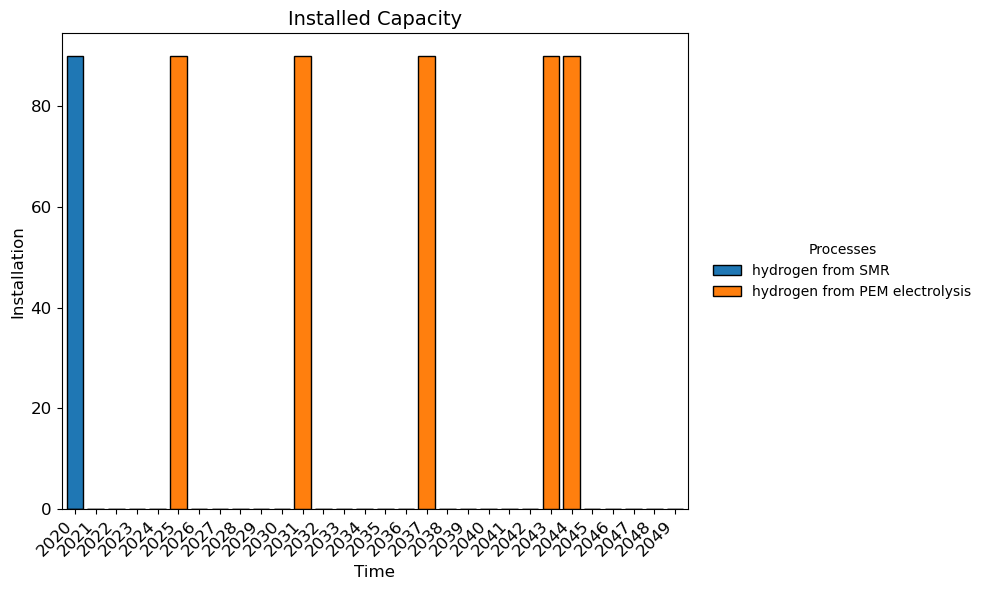

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Installed Capacity'}, xlabel='Time', ylabel='Installation'>)

In [83]:
pp.plot_installation()

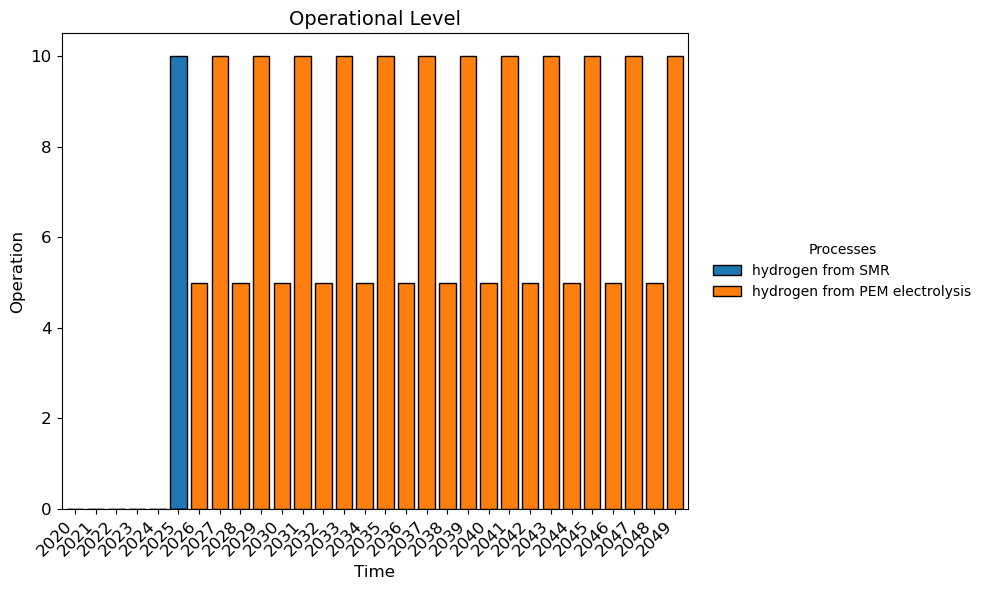

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Operational Level'}, xlabel='Time', ylabel='Operation'>)

In [84]:
pp.plot_operation()

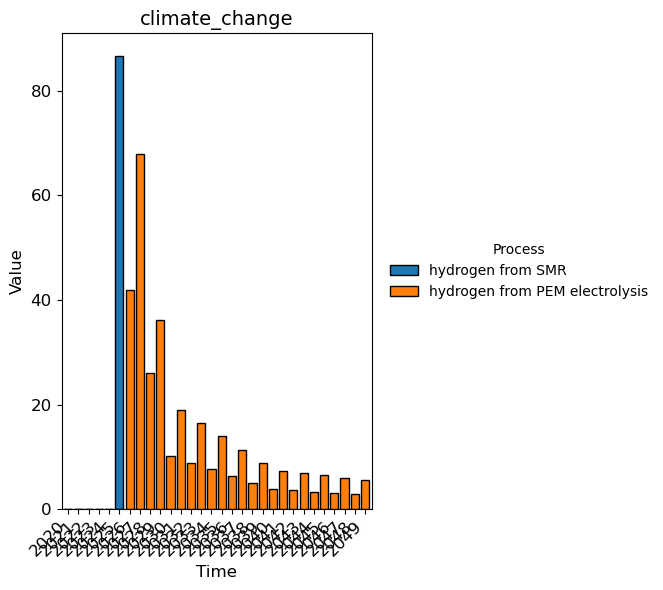

(<Figure size 1000x600 with 1 Axes>,
 array([<Axes: title={'center': 'climate_change'}, xlabel='Time', ylabel='Value'>,
        <Axes: xlabel='Time', ylabel='Value'>], dtype=object))

In [85]:
pp.plot_impacts()

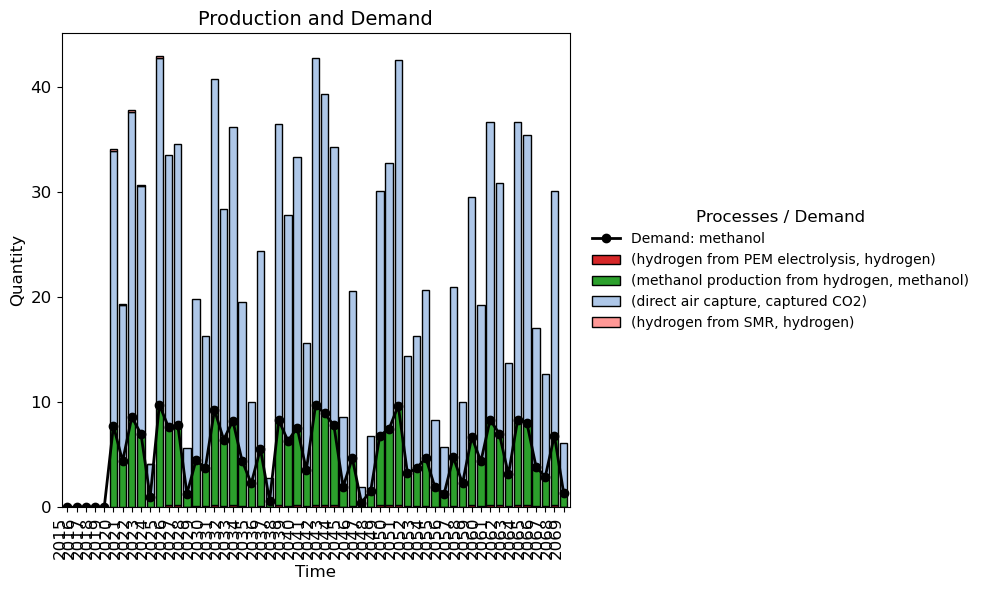

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Production and Demand'}, xlabel='Time', ylabel='Quantity'>)

In [53]:
pp.plot_production_and_demand()

In [34]:
pp.get_impacts()

Category                   climate_change                                   \
Process  b6a60fb2c86e46fcbfbe1a0c3bf3425e c3d0b884a2e648699262b502ae53ab6d   
Time                                                                         
2015                                  0.0                     0.000000e+00   
2016                                  0.0                     0.000000e+00   
2017                                  0.0                     0.000000e+00   
2018                                  0.0                     0.000000e+00   
2019                                  0.0                     0.000000e+00   
2020                                  0.0                     0.000000e+00   
2021                                  0.0                     0.000000e+00   
2022                                  0.0                     0.000000e+00   
2023                                  0.0                     0.000000e+00   
2024                                  0.0                     0.000000e+00   
2025                                  0.0                     0.000000e+00   
2026                                  0.0                     6.759117e-12   
2027                                  0.0                     5.430383e-12   
2028                                  0.0                     4.123261e-12   
2029                                  0.0                     2.837842e-12   
2030                                  0.0                     1.574218e-12   
2031                                  0.0                     1.463040e-12   
2032                                  0.0                     1.353577e-12   
2033                                  0.0                     1.245834e-12   
2034                                  0.0                     1.139820e-12   
2035                                  0.0                     1.035542e-12   
2036                                  0.0                     9.330082e-13   
2037                                  0.0                     8.322260e-13   
2038                                  0.0                     7.332038e-13   
2039                                  0.0                     6.359498e-13   
2040                                  0.0                     5.404727e-13   
2041                                  0.0                     5.191952e-13   
2042                                  0.0                     4.982228e-13   
2043                                  0.0                     4.775569e-13   
2044                                  0.0                     4.571989e-13   
2045                                  0.0                     4.371502e-13   
2046                                  0.0                     4.174122e-13   
2047                                  0.0                     3.979865e-13   
2048                                  0.0                     3.788745e-13   
2049                                  0.0                     3.600779e-13   
2050                                  0.0                     3.415982e-13   
2051                                  0.0                     3.377561e-13   
2052                                  0.0                     3.338973e-13   
2053                                  0.0                     3.300212e-13   
2054                                  0.0                     3.261274e-13   
2055                                  0.0                     3.222155e-13   
2056                                  0.0                     3.182849e-13   
2057                                  0.0                     3.143351e-13   
2058                                  0.0                     3.103656e-13   
2059                                  0.0                     3.063759e-13   
2060                                  0.0                     3.023653e-13   
2061                                  0.0                     2.983333e-13   
2062                                  0.0                     2.942792e-13   
2063                  

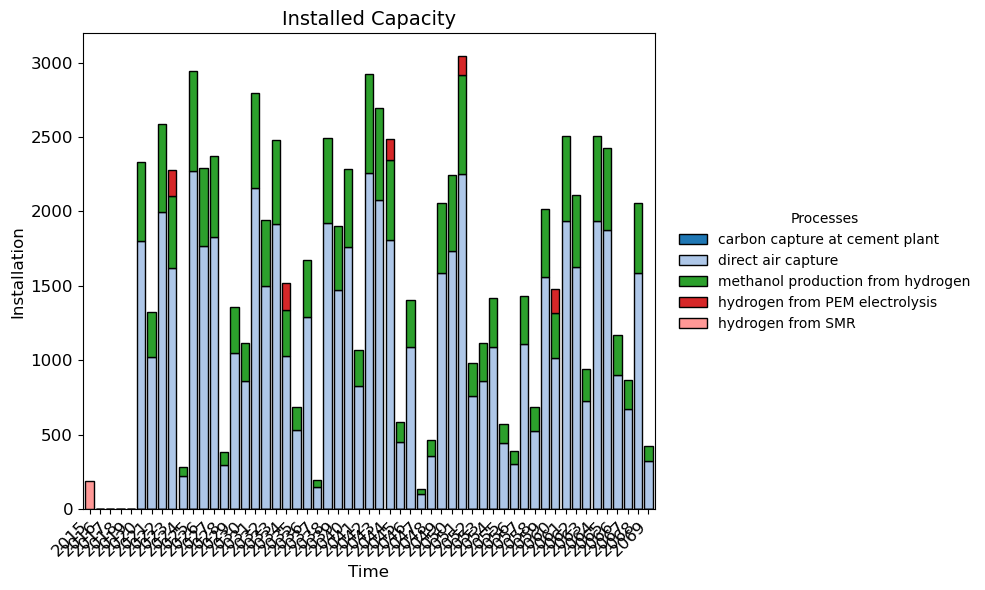

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Installed Capacity'}, xlabel='Time', ylabel='Installation'>)

In [56]:
pp.plot_installation()

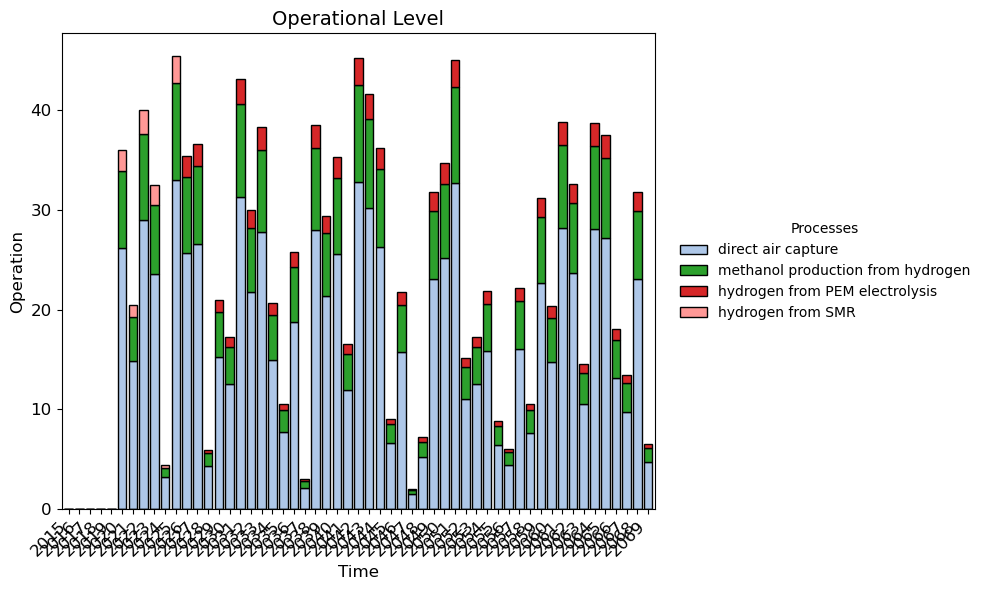

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Operational Level'}, xlabel='Time', ylabel='Operation'>)

In [55]:
pp.plot_operation()

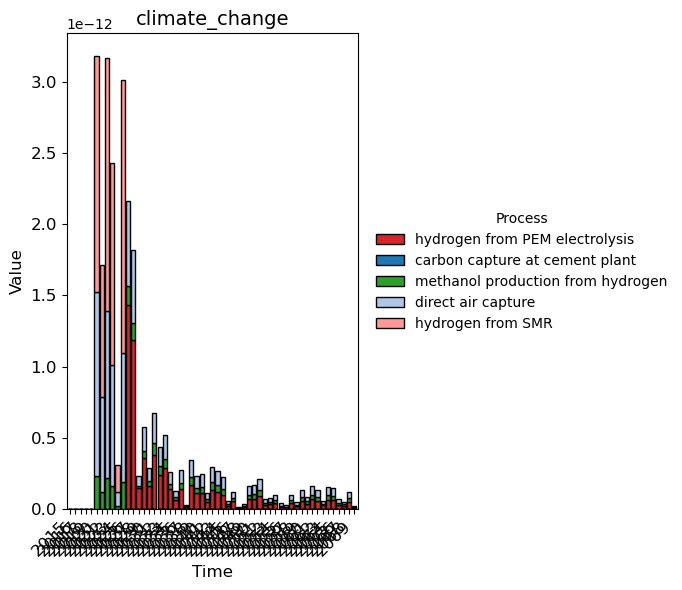

(<Figure size 1000x600 with 1 Axes>,
 array([<Axes: title={'center': 'climate_change'}, xlabel='Time', ylabel='Value'>,
        <Axes: xlabel='Time', ylabel='Value'>], dtype=object))

In [54]:
pp.plot_impacts()

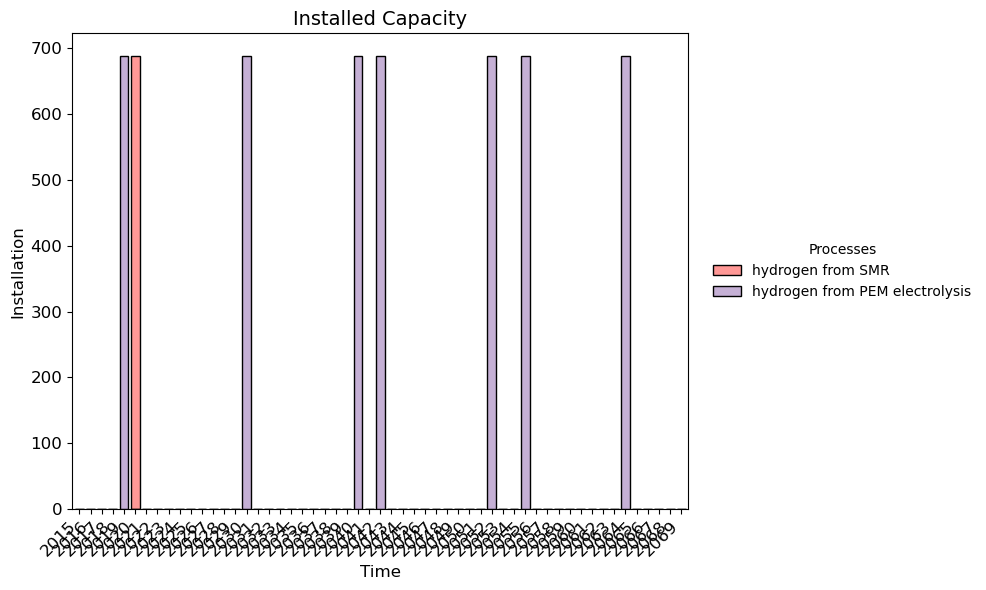

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Installed Capacity'}, xlabel='Time', ylabel='Installation'>)

In [36]:
pp.plot_installation()

In [328]:
m.scales

{'foreground': 4.909090909090909,
 'characterization': {'climate_change': 2.3348057260696622e-11}}

In [30]:
model.scales

{'foreground': 4.909090909090909,
 'characterization': {'climate_change': 2.3348057260696622e-11}}

In [29]:
pp.get_operation()

Process,693b3d79849340fd9f8af7a47041607c,dac305c0bdeb4e6d8fcde37f622240d0
Time,,
2015,0.0,0.0
2016,0.0,0.0
2017,0.0,0.0
2018,0.0,0.0
2019,0.0,0.0
2020,0.0,540.0
2021,0.0,540.0
2022,0.0,540.0
2023,0.0,540.0


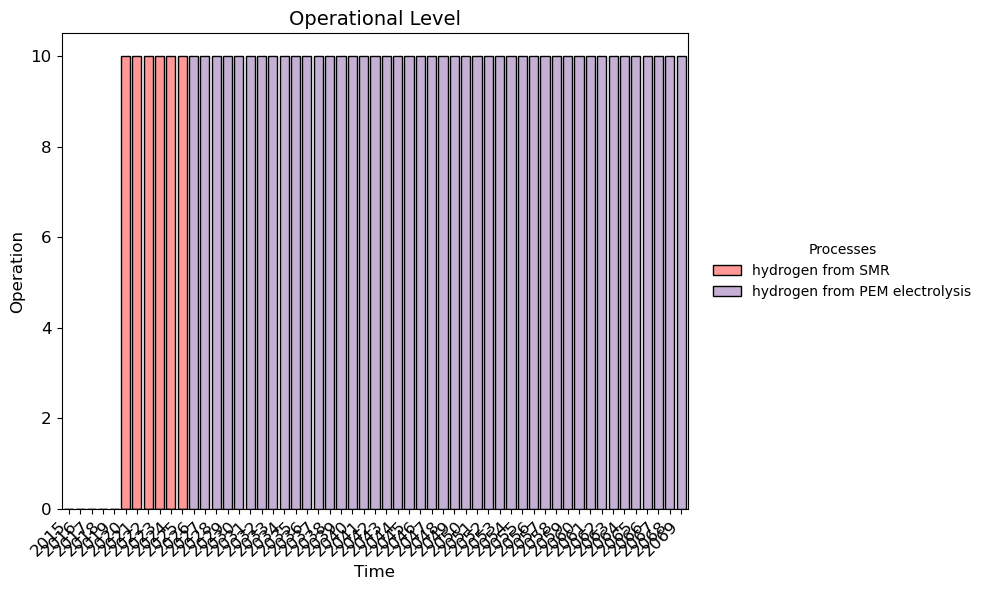

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Operational Level'}, xlabel='Time', ylabel='Operation'>)

In [37]:
pp.plot_operation()

# --------------------------

### Plotting the resulting radiative forcing 

In [319]:
import pyomo.environ as pyo 
fg_scale = getattr(pp.m, "scales", {}).get("foreground", 1.0)
inventory = {
    (p, e, t): pyo.value(pp.m.scaled_inventory[p, e, t]) * fg_scale
    for p in pp.m.PROCESS
    for e in pp.m.ELEMENTARY_FLOW
    for t in pp.m.SYSTEM_TIME
}

import pandas as pd

dynamic_inventory_df = pd.DataFrame.from_records(
    [(p, e, t, v) for (p, e, t), v in inventory.items()],
    columns=["activity", "flow", "date", "amount"]
).astype({
    "activity": "str",
    "flow": "str",
    # "date": "datetime64[s]",
    "amount": "float64"
})

dynamic_inventory_df['date'] = pd.to_datetime(dynamic_inventory_df['date'].astype(int), format='%Y')

In [320]:
dynamic_inventory_df

,activity,flow,date,amount
0,a5d2821e34c24d078e8efdd93b289405,e3e8f6a2-c45e-4685-9859-698b2eadaf5b,2015-01-01,0.0
1,a5d2821e34c24d078e8efdd93b289405,e3e8f6a2-c45e-4685-9859-698b2eadaf5b,2016-01-01,0.0
2,a5d2821e34c24d078e8efdd93b289405,e3e8f6a2-c45e-4685-9859-698b2eadaf5b,2017-01-01,0.0
3,a5d2821e34c24d078e8efdd93b289405,e3e8f6a2-c45e-4685-9859-698b2eadaf5b,2018-01-01,0.0
4,a5d2821e34c24d078e8efdd93b289405,e3e8f6a2-c45e-4685-9859-698b2eadaf5b,2019-01-01,0.0
...,...,...,...,...
92945,34fe9823ae894b6882216398c2ce9029,dcedc211-8daa-49ac-82a9-ce60a22d9b43,2065-01-01,0.0
92946,34fe9823ae894b6882216398c2ce9029,dcedc211-8daa-49ac-82a9-ce60a22d9b43,2066-01-01,0.0
92947,34fe9823ae894b6882216398c2ce9029,dcedc211-8daa-49ac-82a9-ce60a22d9b43,2067-01-01,0.0
92948,34fe9823ae894b6882216398c2ce9029,dcedc211-8daa-49ac-82a9-ce60a22d9b43,2068-01-01,0.0


In [321]:
dynamic_inventory_df["flow"] = dynamic_inventory_df["flow"].apply(
    lambda x: bd.Database("ecoinvent-3.11-biosphere").get(code=x).id
)

In [324]:
from dynamic_characterization import characterize

df_characterized = characterize(
        dynamic_inventory_df,
        metric="radiative_forcing", # could also be GWP
        base_lcia_method=method,
        time_horizon=100,
        fixed_time_horizon=True,
)

2025-12-10 17:27:58.254 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


<Axes: xlabel='date_rounded'>

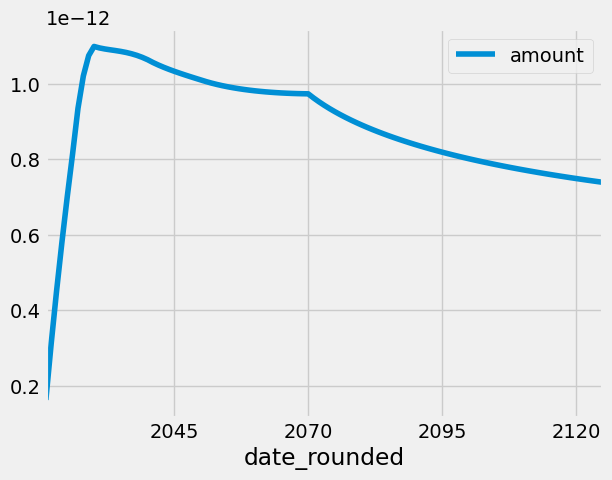

In [326]:
df_characterized['date'] = pd.to_datetime(df_characterized['date'])
df_grouped = (
    df_characterized
    .assign(date_rounded=(df_characterized['date'] + pd.offsets.MonthBegin(6)).dt.to_period('Y').dt.to_timestamp())
    .groupby('date_rounded')['amount'].sum()
    .reset_index()
)

df_grouped.plot(x='date_rounded', y='amount')